### Usage example: Multiverse Analysis

Required comet modules are:
* ```comet.multiverse``` (contains all functions related to multiverse analysis)

To conduct a multiverse analysis, the forking paths must be specified in a dictionary. Options can contain:
* strings
* numerical values
* boolean values
* comet dFC methods
* comet and bct graph measures

In [1]:
from comet.multiverse import Multiverse

forking_paths = {
    "strings": ["Hello", "world"],
    "numbers": [1, 2, 4.2],
    "booleans": [True, False],
    
    "dfc_measures": [{
                        "name": "FLS",
                        "connectivity": "FlexibleLeastSquares",
                        "input_data": "ts",
                        "args": {
                                }
                        },
                        {
                        "name": "JC11",
                        "connectivity": "Jackknife",
                        "input_data": "ts",
                        "args": { 
                                "windowsize": 11,
                                }
                        }],
    
    "graph_measures": [{
                        "name": "eff_bct",
                        "graph": "bct.efficiency_wei",
                        "input_data": "W",
                        "args": {   
                                "local": True,
                                }
                        },
                        {
                        "name": "eff_comet",
                        "graph": "comet.graph.efficiency_wei",
                        "input_data": "W",
                        "args": {   
                                "local": True,
                                }
                        }]
}

# Universes that contain the following decisions (in order, but not required to be contiguous) will not be allowed
invalid_paths = [("Hello", 4.2),
                 ("world", "eff_bct")]

With the decisions and options defined, an analysis template has to be specified. This is similar to a standard analysis pipeline with three additional requirements:

* The template is required to be encapsulated in a dedicated function
* Required imports need to be within the template function
* Decision points need to be specified in double brackets: ```{{decision}}```

In this brief example, the corresponding string, number, and boolean decision will be printed in each universe. Then, connevtivity will be estimated with the corresponding dFC method, and local efficiency is calculated with either the BCT or Comet implementation:

In [2]:
def analysis_template():
    import numpy as np
    import bct
    import comet

    print(f"Decision 1: {{strings}}")
    print(f"Decision 2: {{numbers}}")
    print(f"Decision 3:{{booleans}}")

    # Load example data and calculate dFC + local efficiency
    ts = comet.data.load_example()
    dfc = {{dfc_measures}}
    
    efficiency = np.zeros((ts.shape[0], dfc.shape[1]))
    for i in range(dfc.shape[2]):
        W = dfc[:, :, i]
        W = np.abs(W)
        efficiency[i] = {{graph_measures}}

    print(f"Finished calculating local efficiency. Shape: {efficiency.shape}")

The forking paths dictionary defines 5 decision points consisting of 2 options each. Thus, the resulting multiverse will contain 2⁵=32 universes. A ```Multiverse``` object has to be created and can then be used to create, run, summarize, and visualize the multiverse.

* ```multiverse.create()``` will generate Python scripts for all 32 universes. These scripts will be saved in a newly created ```example_multiverse/``` folder
* ```multiverse.summary()``` will print the decisions for every universe. This information is also available as a .csv in the ```example_multiverse/results/``` folder
* ```multiverse.run()``` will either run all or individual universes. If the computational resources allow for it, this can be parallelized by using e.g. ```multiverse.run(parallel=4)```

,Universe,strings,numbers,booleans,dfc_measures,graph_measures
0,Universe_1,Hello,1.0,True,FLS,eff_bct
1,Universe_2,Hello,1.0,True,FLS,eff_comet
2,Universe_3,Hello,1.0,True,JC11,eff_bct
3,Universe_4,Hello,1.0,True,JC11,eff_comet
4,Universe_5,Hello,1.0,False,FLS,eff_bct


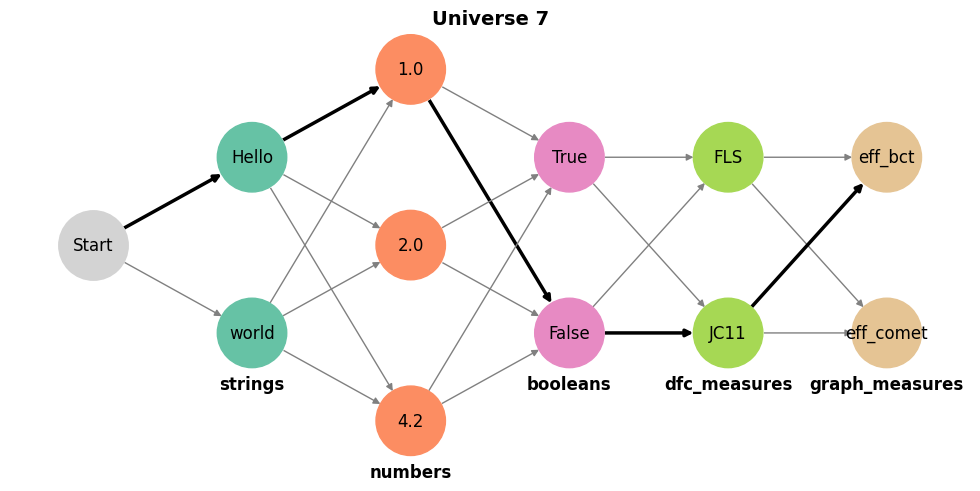

In [4]:
multiverse = Multiverse(name="example_multiverse")
multiverse.create(analysis_template, forking_paths, invalid_paths)
multiverse.summary()
multiverse.visualize(universe=7, node_size=2500, figsize=(10, 5))
#multiverse.run(universe_number=1)